## Load dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, auc, confusion_matrix, make_scorer, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


X_train_banknote = pd.read_csv("../../input/A2-banknote/banknote_X_train.csv")
X_test_banknote = pd.read_csv("../../input/A2-banknote/banknote_X_test.csv")
y_train_banknote = pd.read_csv("../../input/A2-banknote/banknote_y_train.csv")
y_test_banknote = pd.read_csv("../../input/A2-banknote/banknote_y_test.csv")





## MLR algorithm

In [2]:


# set up and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_banknote, y_train_banknote)

# predict outcomes for the test dataset
predicted_values = linear_model.predict(X_test_banknote)

# decide a cutoff point to classify predictions as 0 or 1
cutoff_threshold = 0.5
predicted_classes = (predicted_values > cutoff_threshold).astype(int)

# calculate the accuracy of the model
model_accuracy = np.mean(predicted_classes.ravel() == y_test_banknote.values.ravel())
print("\nMLR Model - Bank Marketing Data")
print("Accuracy: ", model_accuracy)

# show the confusion matrix and ROC AUC score
print("Confusion Matrix:")
print(confusion_matrix(y_test_banknote, predicted_classes))
print("ROC AUC Score: ", roc_auc_score(y_test_banknote, predicted_classes))

# calculate and display the classification error
classification_error = 1 - model_accuracy
print("Classification Error on Test Set:", classification_error)



MLR Model - Bank Marketing Data
Accuracy:  0.9781818181818182
Confusion Matrix:
[[142   6]
 [  0 127]]
ROC AUC Score:  0.9797297297297297
Classification Error on Test Set: 0.021818181818181848


## Cross-validation and parameter turning

In [3]:


class MLRClassifier:
    def __init__(self, threshold=0.5):
        self.regressor = LinearRegression()
        self.threshold = threshold

    def fit(self, X, y):
        self.regressor.fit(X, y)
    
    def predict(self, X):
        predictions = self.regressor.predict(X)
        return (predictions > self.threshold).astype(int)
    
    def get_params(self, deep=True):
        return {"threshold": self.threshold}

    def set_params(self, **parameters):
        for param, value in parameters.items():
            setattr(self, param, value)
        return self

# custom scoring function for accuracy
def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# set up 5-fold cross-validation
cross_validation = KFold(n_splits=5)

# assemble a pipeline with data scaling and the custom classifier
data_processing_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # initial scaler, will be tuned
    ('regressor', MLRClassifier())
])

# scoring method based on accuracy
accuracy_scoring = make_scorer(calculate_accuracy)

# grid for tuning parameters including scalers and threshold
parameter_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'regressor__threshold': [0.4, 0.5, 0.6],
}

# conduct grid search to find the best parameters
parameter_search = GridSearchCV(data_processing_pipeline, parameter_grid, cv=cross_validation, scoring=accuracy_scoring)
parameter_search.fit(X_train_banknote, y_train_banknote)

# display the best parameters and cross-validation score
print("Optimal parameters:", parameter_search.best_params_)
print("Best cross-validation score:", parameter_search.best_score_)

# calculate and display the mean classification error from cross-validation
mean_classification_error = 1 - parameter_search.best_score_
print("Mean Classification Error in Cross-Validation:", mean_classification_error)


Optimal parameters: {'regressor__threshold': 0.6, 'scaler': StandardScaler()}
Best cross-validation score: 0.9844997924449979
Mean Classification Error in Cross-Validation: 0.015500207555002143


## ROC curve and AUC


Bank Marketing Dataset - MLR ROC Curve and AUC


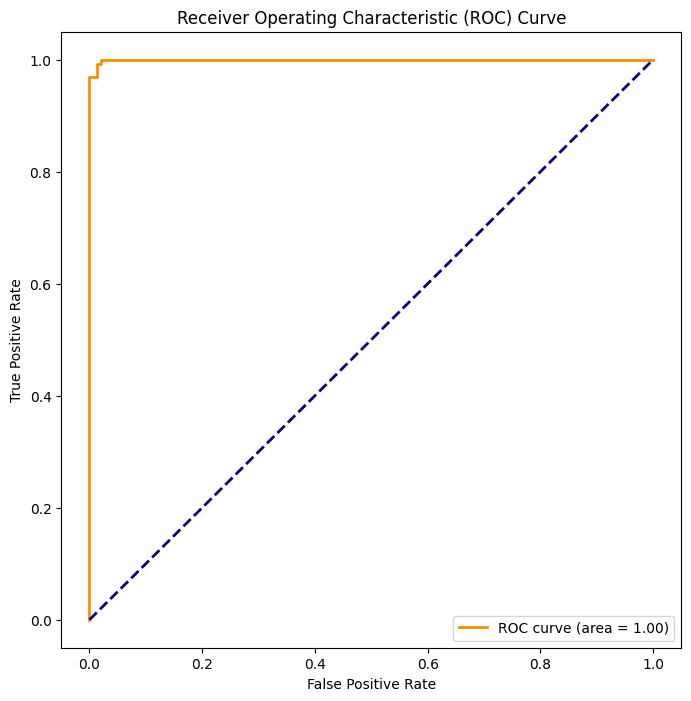

In [4]:


def plot_roc(model, X_test, y_test):
    y_prob = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # plot for the ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# plot ROC curve for MLR on Bank Marketing dataset  
print("\nBank Marketing Dataset - MLR ROC Curve and AUC")
plot_roc(linear_model, X_test_banknote, y_test_banknote)